# Notebook zu Tschebyscheff-Stützstellen und Spline-Interpolation

**Abgabe in den Programmiertutorien am 9. und 10. Januar 2025. Falls Sie Unterstützung bei der Bearbeitung der Programmieraufgabe brauchen, wenden Sie sich frühzeitig an Ihren Tutor oder melden Sie sich im Forum.**

Benötigte Module für dieses Notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Tschebyscheff-Interpolation

Zu $n\in\mathbb{N}$ sind die skalierten Tschebyscheff-Stützstellen $x_0,\ldots,x_n$ im Intervall $[a,b]$ nach der Vorlesung gegeben durch
$$ x_k = \frac{a+b}{2}+\frac{b-a}{2}\cos\left(\frac{(2k+1)\pi}{2n+2}\right), \qquad k=0,\dots,n. $$

**(a) Schreiben Sie eine Prozedur `tscheb_knots(a,b,n)`, die zu gegebenem `a, b, n` die skalierten Tschebyscheff-Stützstellen als Vektor zurückgibt.**

In [3]:
def tscheb_knots(a,b,n):
    result = (a+b)/2 + (b-a)/2 * np.cos( (2*np.arange(n+1)+1)*np.pi/(2*n+2) )
    return result

Zur Überprüfung: Die drei Tschebyscheff-Stützstellen im Intervall $[0,3]$ sind gegeben durch $x_0 \approx 0.20096189, \ x_1 = 1.5, \ x_2 \approx 2.79903811$.

In [4]:
tscheb_knots(0,3,2)

array([2.79903811, 1.5       , 0.20096189])

**Zusatz: Wenn Ihre Prozedur `tscheb_knots` funktioniert, demonstriert Ihnen das folgende Programm, wie die Tschebyscheff-Stützstellen in einem Intervall $[a,b]$ für verschiedene Werte von $n$ verteilt sind.**

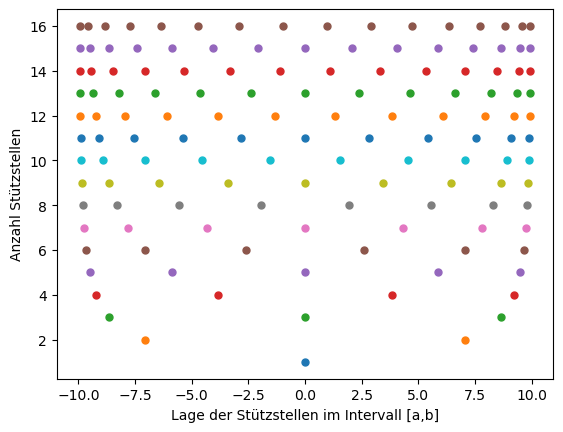

In [5]:
N = 16
a = -10
b = 10
for n in range(1,N+1):     
    knots = tscheb_knots(a,b,n-1)
    plt.plot(knots, n*np.ones(n), "o", markersize=5)

plt.xlabel('Lage der Stützstellen im Intervall [a,b]')
plt.ylabel('Anzahl Stützstellen')
plt.show()

**(b) Benutzen Sie die Prozedur `plot_IP` aus der Programmieraufgabe 3 (dafür benötigen Sie zusätzlich die Prozeduren `div_diff` und `horner_newton` aus dem entsprechenden Notebook), um das Interpolationspolynom unter Verwendung von Tschebyscheff-Stützstellen zu visualisieren. Benutzen Sie hierfür wieder die Funktion $f:[-1,1] \to \mathbb{R}, x\mapsto \frac{1}{1+(5x)^2}$ und testen Sie die Stützstellenzahlen $10, 20$ und $40$. Vergleichen Sie das Ergebnis mit dem IP unter Verwendung von der selben Anzahl an äquidistanten Stützstellen. Was beobachten Sie und wie können Sie das Verhalten begründen?**

_Hinweis:_ Ein Lösungsvorschlag zur Programmieraufgabe 3 steht ab Freitag, dem 13.12.24, im Ilias zur Verfügung.

**Lösung:**

In [6]:
def div_diff(knots,vals):
    Delta = np.zeros((len(knots),len(knots)))
    Delta[:,0] = vals
    for j in range(1,len(knots)):
         for i in range(j,len(knots)):
             Delta[i,j] = (Delta[i,j-1] - Delta[i-1,j-1]) / (knots[i]-knots[i-j])
 
    return Delta

def horner_newton(d, knots, x):
    # d enthält die Koeffizienten d_0, ..., d_n, insgesamt also n+1 Stück
    n = len(d) - 1      
    
    px = d[n]   
    for i in range(n-1, -1, -1):
        px = d[i] + (x-knots[i]) * px 
    return px

def plot_IP(f,a,b,knots,title):
    # Berechnung der Koeffizienten des IPs in Newton-Darstellung
    vals = f(knots)
    Delta = div_diff(knots,vals)
    d = np.diag(Delta) 

    # Plot von f
    x = np.linspace(a,b,1000)
    plt.plot(x,f(x),label = 'f')

    # Plot des IPs
    plt.plot(x,horner_newton(d,knots,x),label = 'IP')

    # Markierung der Interpolationspunkte
    plt.plot(knots,vals,'ro', label = 'Stützpunkte')

    plt.title(title)
    plt.legend()
    plt.show()

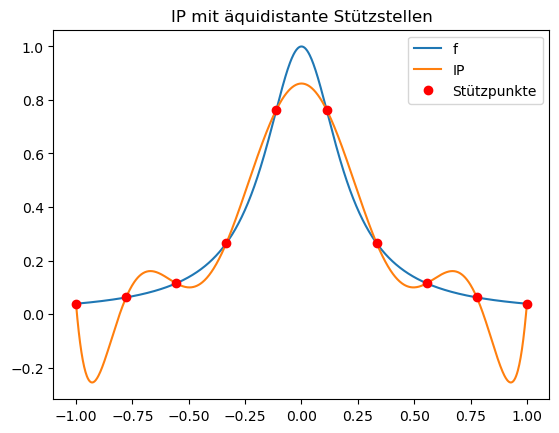

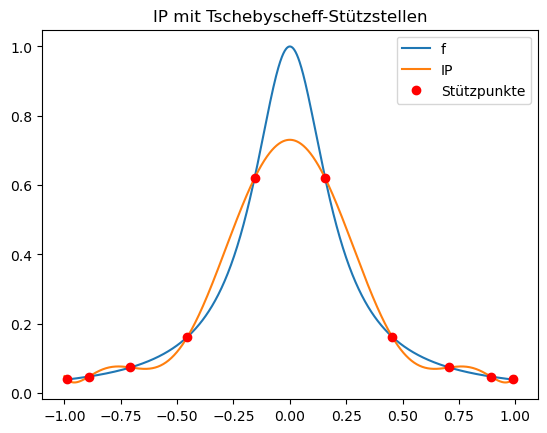

In [7]:
def f(x):
    return 1/(1+(5*x)**2)

a = -1
b = 1
n = 10 #20#40 # Anzahl Stützstellen
knots_equi = np.linspace(a,b,n)
knots_tscheb = tscheb_knots(a,b,n-1)
plot_IP(f,a,b,knots_equi,"IP mit äquidistante Stützstellen")
plot_IP(f,a,b,knots_tscheb,"IP mit Tschebyscheff-Stützstellen")

Für größere Stützstellenzahlen erkennt man, dass die Interpolationspolynome mit Tschebyscheff-Stützstellen gegen die Funktion $f$ konvergieren, da die Wahl der Stützstellen den Interpolationsfehlers optimieren (siehe Abschnitt nach Lemma 2.15). Im Fall von äquidistanten Stützstellen wird durch die Plots erkenntlich, dass am Rand des Intervalls große Abweichungen auftreten (siehe `Notebook_NewtonIP` Aufgabe 3c). 

# 2. Spline-Interpolation

In dieser Aufgabe implementieren wir den eingespannten, kubischen interpolierenden Spline. Dabei nehmen wir an, dass die Stützstellen $x_0,\ldots,x_n$ äquidistant sind, also $x_i-x_{i-1}=\frac{b-a}n =:h$ für $i=1,\ldots,n$ gilt. 

Zunächst bestimmen wir die noch unbekannte Ableitungswerte $v_i = s_i'(x_{i})$ durch Lösung des LGS aus Beispiel 2.28.

**(a) Programmieren Sie eine Prozedur `derivative_val`, welches zu gegebenen Intervallgrenzen $a,b\in\mathbb{R}$ mit $a<b$, Funktionswerten $y_i = s(x_i), i=0,\ldots,n$ und Randableitungen $v_0=s'(a)$, $v_n = s'(b)$ das Lineare Gleichungssystem in Beispiel 2.28 durch Elimination löst und den Vektor $v=(v_0,\ldots,v_n)$ aller Ableitungswerte ausgibt.**

**Lösung:**

In [8]:
def derivative_val(y,v_0,v_n,a,b):
    n = len(y)-1 
    h = (b-a)/n
    x = np.linspace(a,b,n+1)

    # Vektoren c und d berechnen:
    c = np.zeros(n)
    d = np.zeros(n)
    # Erster Eintrag
    c[1] = (3*(y[2]-y[0]))/h - v_0
    d[1] = 4
    # Einträge 2 bis n-2
    for k in range(1,n-2):
        d[k+1] = 4 - 1/d[k]
        c[k+1] = (3*(y[k+2] - y[k]))/h - c[k]/d[k]
    # Letzter (n-1-ter) Eintrag:    
    d[n-1] = 4 - 1/d[n-2]
    c[n-1] = (3*(y[n] - y[n-2]))/h - v_n - c[n-2]/d[n-2]

    # Vektor v berechnen (von unten nach oben)
    v = np.zeros(n+1)
    v[n-1] = c[n-1]/d[n-1]
    for k in range(n-2, 0 , -1):
        v[k] = (c[k]-v[k+1])/d[k]
    # vorgegebene Randwerte ergänzen
    v[0] = v_0
    v[n] = v_n
    
    return v

**(b) Überprüfe Sie das Ergebnis aus ihrer Prozedur `derivative_val`, indem Sie überprüfen, ob der Ergebnisvektor `v` tatsächlich eine Lösung des Gleichungssystems $hA (v_1,\ldots,v_{n-1})^T = hb$ ist. Stellen Sie dazu die Matrix $hA$ und den Vektor $hb$ auf und überprüfen Sie, ob das Produkt $hA (v_1,\ldots,v_{n-1})^T$ tatsächlich dem Vektor $hb$ entspricht. Beachten Sie, dass der Ergebnisvektor `v` der Prozedur `derivative_val` zusätzlich die Einträge $v_0$ und $v_n$ enthält. Verwenden Sie die unten angebenenen (willkürlichen) Daten für $a,b,n,y,v_0$ und $v_n$.**

_Hinweis:_ Um die Matrix $hA$ aufzustellen kann der Befehl `np.diag` hilfreich sein, um die Nebendiagonalen geschickt zu erzeugen.

In [9]:
a = 0; b = 5
n = 10
y = np.arange(0,n+1)**2
v_0 = 1
v_n = 2

# Ergebnis der Prozedur:
v = derivative_val(y,v_0,v_n,a,b)

# Matrix hA und Vektor hb aufstellen:
h = (b-a)/n
hA = 4*np.eye(n-1) + np.diag(np.ones(n-2),k=-1) + np.diag(np.ones(n-2),k=1)
hb = 3*(y[2:n+1]-y[0:n-1])/h
hb[0] = hb[0] - v_0
hb[-1] = hb[-1] - v_n 

# Überprüfen, ob hA*v tatsächlich dem Vektor hb entspricht:
print('Fehler zwischen hb und hA*v in der Maximumsnorm:')
print( max(abs(hb - hA@v[1:n])) )


Fehler zwischen hb und hA*v in der Maximumsnorm:
1.4210854715202004e-14


**(c) Implementieren Sie eine Prozedur `s_i(x0,x1,y0,y1,v0,v1,x)`, die das kubische Teilpolynom zu Stützstellen $x_0$ und $x_1$, Funktionswerten $y_0$ und $y_1$ sowie Ableitungswerten $v_0$ und $v_1$ an einer Stelle $x$ auswertet. Verwenden sie dazu die Darstellung aus dem Abschnitt "Konstruktion von kubischen interpolierenden Splines" des Skripts, welche Sie mit der Prozedur `horner_newton` aus Programmieraufgabe 3 einfach auswerten können.** 

_Hinweis:_ Das kubische Polynom $p$ zu den Daten $p(0) = 1, \ p(1) =2, \ p'(0)=3, \ p'(1) = 4$ ist gegeben durch $p(x) = 5x^3 - 7x^2 + 3x + 1$ und es gilt $p(0.5) = 1.375$. Überprüfen Sie, ob Ihre Prozedur das selbe Ergebnis liefert.

**Lösung:**

In [10]:
def s_i(x0,x1,y0,y1,v0,v1,x):
    h = x1-x0
    knots = np.array([x0, x0, x1, x1])
    d = np.zeros(4)
    d[0] = y0
    d[1] = v0
    delta_y = (y1-y0)/h
    d[2] = (delta_y-v0)/h
    d[3] = (v1-2*delta_y+v0)/(h**2)
    return horner_newton(d, knots ,x)

In [11]:
s_i(0,1,1,2,3,4,0.5)

1.375

**(d) Schreiben Sie eine Prozedur `plot_spline`, die zu einer gegebenen Funktion $f$, einem Intervall $[a,b]$, einer Stützstellenzahl $n_{knots}$ sowie Randableitungen $v_a$ und $v_b$ den eingespannten, kubischen interpolierenden Spline zu äquidistanten Stützstellen und mit den exkaten Funktionswerten $y_i = f(x_i)$ plottet. Berechnen Sie dazu zunächst alle Ableitungswerte $v_i$ mit der Prozedur `derivative_val` aus Teil (a) und plotten Sie anschließend ein Teilpolynom $s_i$ nach dem anderen mithilfe der Prozedur `s_i` aus Teil (c). Ergänzen Sie auch ein Bild der Funktion $f$ selbst.**

**Wenden Sie ihre Prozedur dann auf die Funktion $f:[-1,1] \to \mathbb{R}, x\mapsto \frac{1}{1+(5x)^2}$ aus Aufgabe 1 (b) an. Verwenden Sie zunächst 7 Stützstellen und die exakten Ableitungswerte $f'(-1) = \frac{25}{338}$ und $f'(1) = -\frac{25}{338}$. Erhöhen Sie dann die Anzahl an Stützstellen auf 
$9$, $11$ und $21$. Was beobachten Sie? Vergleichen Sie auch die Qualität des Splines mit dem Tschebyscheff-Interpolationspolynom mit den selben Stützstellenzahlen.**

In [12]:
def plot_spline(f,a,b,n_knots,v_a,v_b):
    # Funktionswerte
    knots = np.linspace(a,b,n_knots)
    y = f(knots)

    # Plot von f
    x = np.linspace(a,b,1000)
    plt.plot(x,f(x),label='Funktion f')
    
    # Ableitungswerte    
    v = derivative_val(y,v_a,v_b,a,b)

    # Plot der Teilpolynome (wir plotten jedes Teilpolynom pauschal an 50 Stellen)
    for i in range(0,n_knots-1):
        x = np.linspace(knots[i],knots[i+1], 50)
        s_vals = s_i(knots[i],knots[i+1],y[i],y[i+1],v[i],v[i+1], x)
        plt.plot(x, s_vals)
        
    plt.legend()
    plt.show()

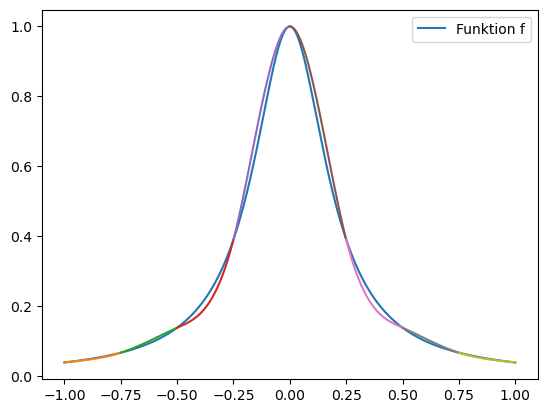

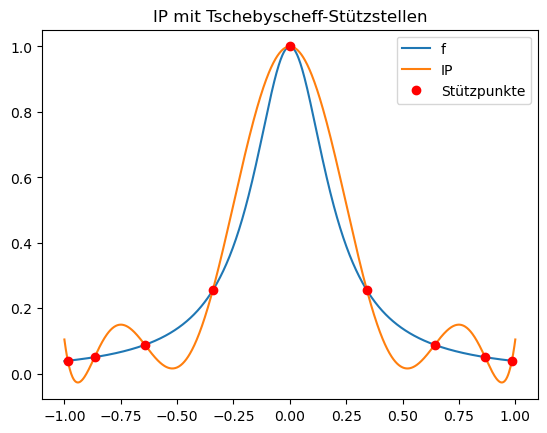

In [13]:
def f(x):
    return 1/(1+(5*x)**2)
    
a = -1
b = 1
n_knots = 9

# Spline
v_a = 25/338; v_b = -25/338
#v_a = 2; v_b = 2
plot_spline(f,a,b,n_knots,v_a,v_b)

# Tschebyscheff-IP
plot_IP(f,a,b,tscheb_knots(a,b,n_knots-1),"IP mit Tschebyscheff-Stützstellen")


**Lösung:** Der kubische interpolierende Spline mit korrekten Randbedingungen konvergiert besser gegen die Funktion $f$ als das IP mit Tschebyscheff-Stützstellen für größere Anzahl an Stützstellen $n$. Das liegt daran, dass auch für größe Stützstellenzahlen nur die 4-te Ableitung von $f$ in der Fehlerabschätzung des Splines relevant ist, d.h. die explodierenden größeren Ableitungen der hier gewählten Funktion $f$ keine Rolle spielen.

**(e) Was passiert, wenn Sie die Randableitungen in Teil (d) durch die _falschen_ Werte $v_a = 2$ und $v_b=2$ ersetzen?**

**Lösung:** In der Mitte immernoch gute Approximation der Funktion $f$, nur am Rand kleiner werdende Ausschläge verursacht durch die fehlerhaften Randbedingungen.